# Pre-Processing of Bank Dataset


In [19]:
# Environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
# custom library
!pip install git+https://github.com/junclemente/jcds.git

from jcds import reports as jrep
from jcds import eda as jeda

  Cloning https://github.com/junclemente/jcds.git to /tmp/pip-req-build-tf3vosat
  Running command git clone --filter=blob:none --quiet https://github.com/junclemente/jcds.git /tmp/pip-req-build-tf3vosat
  Resolved https://github.com/junclemente/jcds.git to commit 0cefd660ed373ab7044e285e406a7063cda8d4f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
datasets = Path("../datasets")

df = pd.read_csv(datasets / "bank-additional-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Numerical Features


### Cardinality Report

In [ ]:
jrep.data_cardinality(df, show_columns=True)

CARDINALITY REPORT

Total columns analyzed: 21

[BINARY COLUMNS]
There are 2 binary columns.
 * Columns: ['contact', 'y']
There are 0 binary with nan.

[CONSTANT/NEAR CONSTANT COLUMNS]
There are 0 constant columns.
There are 1 near-constant columns with >= 95% of values being the same.
 * Columns: ['pdays']

[LOW CARDINALITY CATEGORICAL COLUMNS]
 * There are 10 low cardinality columns with <= 10 unique values.
Columns:
 * marital: 4 unique values
 * education: 8 unique values
 * default: 3 unique values
 * housing: 3 unique values
 * loan: 3 unique values
 * contact: 2 unique values
 * month: 10 unique values
 * day_of_week: 5 unique values
 * poutcome: 3 unique values
 * y: 2 unique values

[HIGH CARDINALITY CATEGORICAL COLUMNS]
 * There are 0 high cardinality variables with >=90% unique values.


### Outliers

In [ ]:
# get total count of outliers
outliers = jeda.detect_outliers_iqr(df)

# create dataframe
outliers_df = pd.DataFrame(list(outliers.items()), columns=["feature", "count"])
display(outliers_df)

,feature,count
0,age,469
1,duration,2963
2,campaign,2406
3,pdays,1515
4,previous,5625
5,emp.var.rate,0
6,cons.price.idx,0
7,cons.conf.idx,447
8,euribor3m,0
9,nr.employed,0


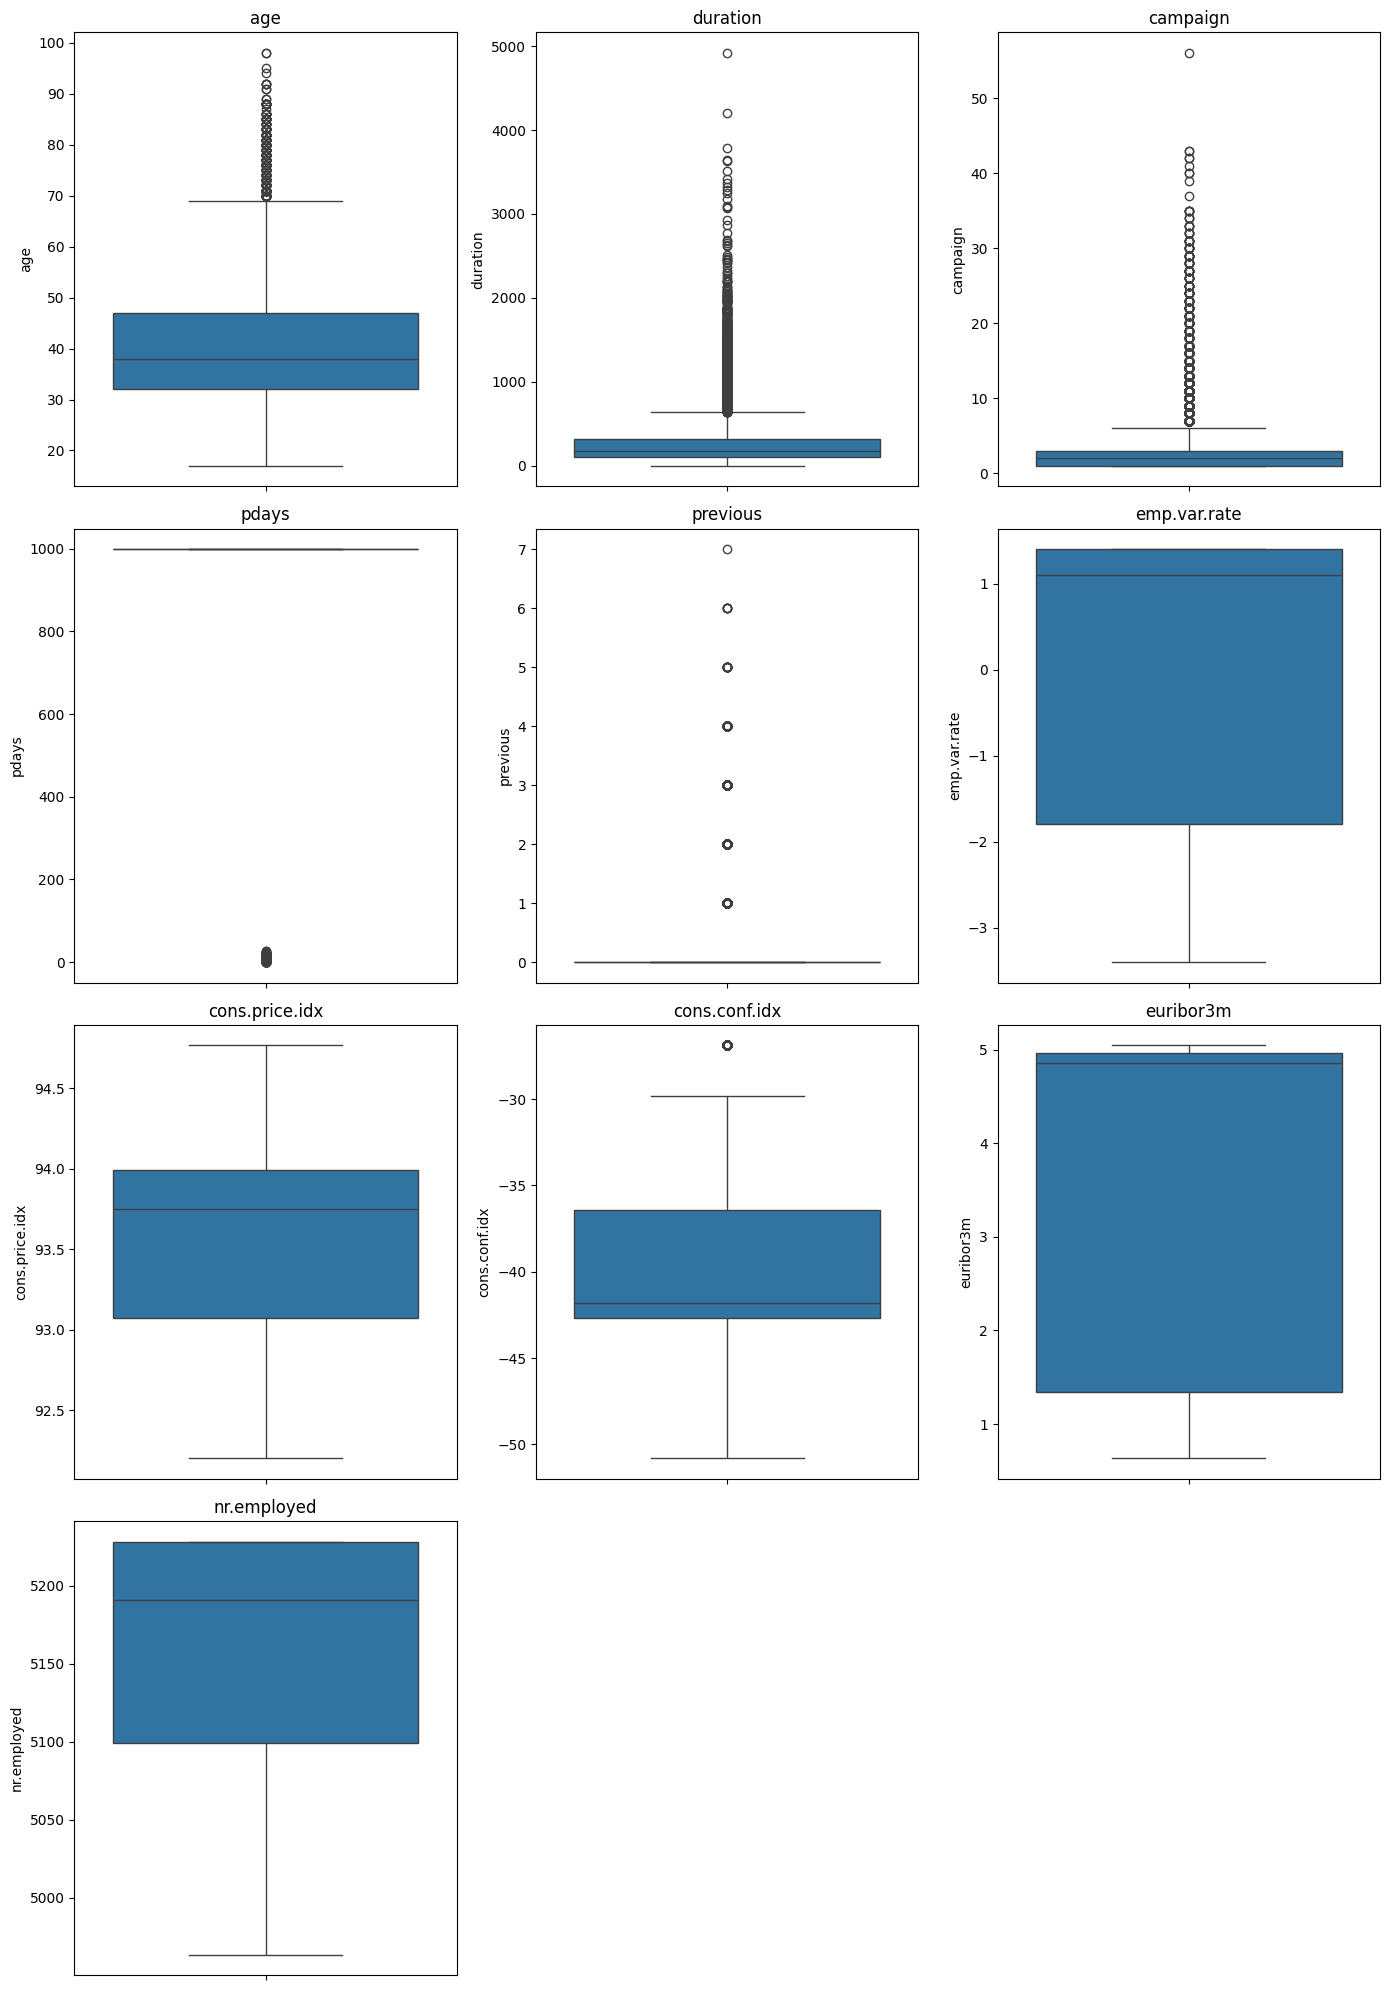

In [ ]:
jeda.plot_outlier_boxplots(df)

### Observation


Six of the numerical variables have outliers.

1. **age outliers:** 70 - 100. These appear to be legitimate ages. No processing needed, maybe center/scale transform.
2. **duration:** based on data dictionary, this feature is highly correlated with target and should be removed.
3. **campaign:** There are 2406 detected outlies and showing a right skew. Transform to center/scale should be considered.
4. **pdays:** This could be converted to binary.
5. **previous:** Represents the number of times a customer was contacted prior to the campaign. This could be converted to binary: contacted vs not contacted.
6. **cons.conf.idx:** Total 447 outliers detected. Based on distribution from EDA, maybe this can be binned or turned to categorical.

Possible multicolinearity:

- euribor3m and emp.var.rate
- nr.employed and emp.var.rate

- cons.price.idx and emp.var.rate

- pdays and previous


## Categorical Features


### Observations

- marital: does not show much variability; may not be a good predictor
- housing: does not show much variability; not a good predictor unless `unknown` could have information
- loan: same as housing, does not show much variability. Also has a `unknown`
- day_of_week: does not show much variability; may not be a good predictor

Based on chi_2 stat, `housing` and `loan` are not statistically significant with p-value > 0.05.


With the Cramer's V statistic, `marital` and `day_of_week` do not show strong association with the target, `0.5`, and `0.3` respectively. These may not be good predictors and could be candidates for removal from the final dataset for modeling.


## Variables to Drop

Due to multicollinearity with `emp.var.rate`, the following numerical features will be dropped:

- euribor3m
- nr.employed
- cons.price.idx

_Out of these four numerical features, without someone with domain knowledge, generative AI was asked which feature would be best to keep. ChatGPT recommended keeping `emp.var.rate` due to "strong economic indicator, lower redundancy, and most interpretable."_

`pdays` and `previous` also show colinearity. Consder converting `pdays` to binary and dropping `previous` as it is not a strong predictor of the target.

Due to low statistical significance and low strength of association, the following categorical features will be dropped:

- housing
- loan


# Transformation Pipelines

In [ ]:
jrep.data_info(df, show_columns=True)


SHAPE:
There are 41188 rows and 21 columns (30.26 MB).

DUPLICATES:
There are 12 duplicated rows.

COLUMNS/VARIABLES:
Column dType Summary:
 * object: 11
 * int: 5
 * float: 5
There are 10 numerical (int/float/bool) variables.
 * Columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
There are 11 categorical (nominal/ordinal) variables.
 * Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

DATETIME COLUMNS:
There are 0 datetime variables and 0 possible datetime variables.

OTHER COLUMN/VARIABLE INFO:
ID Like Columns (threshold = 95.0%): 0
Columns with mixed datatypes: 0
 * Columns: []


In [ ]:
# get feature list by type
cat_var = jeda.show_catvar(df)
con_var = jeda.show_convar(df)
target = "y"

# remove target from categorical list
cat_var = [col for col in cat_var if col != target]

print(f"Categorical variables:", cat_var)
print(f"Continuous variables:", con_var)

Categorical variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Continuous variables: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [ ]:
cols_to_drop = ['housing', 
'loan', 
'previous', 
'pdays', # after converting to binary
'euribor3m', 
'nr.employed', 
'cons.price.idx']

convert_to_binary = ['pdays']

## Train / Test Split

In [ ]:
RANDOM_STATE = 42
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_STATE)

## Define Pipeline Tranformeers

In [ ]:
# columns to drop
drop_columns = FunctionTransformer(lambda X: X.drop(columns=cols_to_drop), validate=False)

# convert pdays to binary
def pdays_to_binary(X):
    X = X.copy()
    X['pdays_binary'] = (X['pdays'] != 999).astype(int)

convert_to_binary = FunctionTransformer(pdays_to_binary, validate = False)

# scaler and encoder
preprocessor = ColumnTransformer(transformers = [
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline = Pipeline(steps = [
    ('drop', drop_columns), 
    ('bin', convert_to_binary), 
    ('preprocess', preprocessor), 
    # ('smote', SMOTE(random_state=RANDOM_STATE)), # Only used on training dataset
])